# Prediction skill of temperature and specific humidity tendencies

### Importing packages and data_utils.py

In [1]:
from climsim_utils.data_utils import *

In [22]:
class data_utils_savepdf(data_utils):
    def plot_r2_analysis(self, pressure_grid_plotting, save_path='', tendency='heating', figsize = (48,18), suptitle=''):
        '''
        Plot R² analysis for heating or moistening tendency across multiple models.
        
        Parameters:
        - pressure_grid_plotting: Pressure grid data for plotting.
        - save_path (str): File path to save the figure.
        - tendency (str): Choose 'heating' or 'moistening' to specify which tendency to plot.
        '''
        assert tendency in ['heating', 'moistening'], "tendency must be 'heating' or 'moistening'"
        
        self.set_plot_params()
        
        # Models to be plotted
        self.model_names = ['CNN', 'ED', 'HSR', 'MLP', 'RPN', 'cVAE', 'UNET']
        n_model = len(self.model_names)
        
        # Plot Configuration
        fig, ax = plt.subplots(2, 4, figsize=figsize)
        y = np.array(range(60))
        X, Y = np.meshgrid(np.sin(self.lats * np.pi / 180), y)
        Y = pressure_grid_plotting / 100
        
        test_heat_daily_long, test_moist_daily_long = self.reshape_daily(self.target_scoring)
        
        # Loop through models and plot
        for i, model_name in enumerate(self.model_names):
            row, col = divmod(i, 4)  # Determine row and column in grid
            pred_heat_daily_long, pred_moist_daily_long = self.reshape_daily(self.preds_scoring[model_name])
            
            if tendency == 'heating':
                coeff = 1 - np.sum((pred_heat_daily_long - test_heat_daily_long)**2, axis=1) / \
                            np.sum((test_heat_daily_long - np.mean(test_heat_daily_long, axis=1)[:, None, :])**2, axis=1)
                title = f"{model_name} - Heating"
            else:
                coeff = 1 - np.sum((pred_moist_daily_long - test_moist_daily_long)**2, axis=1) / \
                            np.sum((test_moist_daily_long - np.mean(test_moist_daily_long, axis=1)[:, None, :])**2, axis=1)
                title = f"{model_name} - Moistening"
            
            coeff = coeff[self.sort_lat_key, :]
            coeff = coeff.T
            
            contour_plot = ax[row, col].pcolor(X, Y, coeff, cmap='Blues', vmin=0, vmax=1, rasterized=True)
            ax[row, col].contour(X, Y, coeff, [0.7], colors='orange', linewidths=[4])
            ax[row, col].contour(X, Y, coeff, [0.9], colors='yellow', linewidths=[4])
            ax[row, col].set_ylim(ax[row, col].get_ylim()[::-1])
            ax[row, col].set_title(title)
            ax[row, col].set_xticks([])
            
            if col != 0:
                ax[row, col].set_yticks([])
        
        # Hide the last panel (8th panel)
        ax[1, 3].axis('off')
        
        # Label axes
        ax[0, 0].set_ylabel("Pressure [hPa]")

        ax[1, 0].set_ylabel("Pressure [hPa]")
        ax[0, 0].yaxis.set_ticks([1000, 800, 600, 400, 200, 0])
        ax[1, 0].yaxis.set_ticks([1000, 800, 600, 400, 200, 0])

        minor_tick_positions = [np.sin(angle / 180 * np.pi) for angle in range(-80, 81, 10)]
        
        # ax[1, 0].xaxis.set_ticks([np.sin(-50 / 180 * np.pi), 0, np.sin(50 / 180 * np.pi)])
        # ax[1, 0].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
        # # Minor ticks every 10° from -90° to 90°
        # ax[1, 0].xaxis.set_ticks(minor_tick_positions, minor=True)
        # ax[1, 0].xaxis.set_tick_params(which='minor', width=1, length=4, color='gray')

        # ax[1, 0].xaxis.set_tick_params(width=2)

        # ax[1, 1].xaxis.set_ticks([np.sin(-50 / 180 * np.pi), 0, np.sin(50 / 180 * np.pi)])
        # ax[1, 1].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
        # ax[1, 1].xaxis.set_tick_params(width=2)
        # ax[1, 1].xaxis.set_ticks(minor_tick_positions, minor=True)
        # ax[1, 1].xaxis.set_tick_params(which='minor', width=1, length=4, color='gray')

        # ax[1, 2].xaxis.set_ticks([np.sin(-50 / 180 * np.pi), 0, np.sin(50 / 180 * np.pi)])
        # ax[1, 2].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
        # ax[1, 2].xaxis.set_tick_params(width=2)
        # ax[1, 2].xaxis.set_ticks(minor_tick_positions, minor=True)
        # ax[1, 2].xaxis.set_tick_params(which='minor', width=1, length=4, color='gray')

        ax[1, 0].set_xlabel("Latitude")
        ax[1, 1].set_xlabel("Latitude")
        ax[1, 2].set_xlabel("Latitude")
        
        for i in range(2):
            for j in range(4):
                ax[i, j].xaxis.set_ticks([np.sin(-50 / 180 * np.pi), 0, np.sin(50 / 180 * np.pi)])
                ax[i, j].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
                # Minor ticks every 10° from -90° to 90°
                ax[i, j].xaxis.set_ticks(minor_tick_positions, minor=True)
                ax[i, j].xaxis.set_tick_params(which='minor', width=2, length=8, color='gray')
        
                ax[i, j].xaxis.set_tick_params(width=2, length=8)
        
        
        # Colorbar
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.87, 0.12, 0.02, 0.76])
        cb = fig.colorbar(contour_plot, cax=cbar_ax)
        cb.set_label("Skill Score " + r'$\left(\mathrm{R^{2}}\right)$', labelpad=50.1)
        
        # Title and layout
        tendency_title = "Heating" if tendency == 'heating' else "Moistening"
        plt.suptitle(suptitle, y=0.97)
        plt.subplots_adjust(hspace=0.20, wspace=0.1)
        
        # Save and display
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=100)
        plt.show()

### Instantiating class

In [23]:
#!pip install --upgrade netcdf4 h5py

In [24]:
grid_path = '/jet/home/zhuc/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'
norm_path = '/jet/home/zhuc/ClimSim/preprocessing/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')


In [25]:
scoring_data = data_utils_savepdf(grid_info = grid_info, 
                          input_mean = input_mean, 
                          input_max = input_max, 
                          input_min = input_min, 
                          output_scale = output_scale)

### Loading data and setting pressure grid

In [26]:
# paths to scoring data
input_scoring_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy'
target_scoring_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy'
# input_scoring_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy'
# target_scoring_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy'

# paths to model predictions
cvae_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/cVAE/cvae_preds_manual.h5'
ed_pred_path = '/ocean/projects/atm200007p/behrens/ED_Behrens_2022/ED_ClimSIM_1_3_pred.npy'
hsr_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/HSR/hsr_preds_bestcrps.h5'
rpn_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/RPN/rpn_pred_v1_stride6.npy'
cnn_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/CNN/val_predict_cnn_reshaped_stride6_FINAL.npy'
mlp_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/MLP/001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy'
unet_pred_path = '/ocean/projects/ees230010p/zhuc/score_nnoutput_unetv1.npy'


# set path to original data
scoring_data.data_path = '/ocean/projects/atm200007p/jlin96/ClimSim_low-res-test/'

# path to target input
scoring_data.input_scoring = np.load(input_scoring_path)

# path to target output
scoring_data.target_scoring = np.load(target_scoring_path)

In [27]:
# set pressure weights
# scoring_data.set_pressure_grid(data_split = 'scoring')

# set regular expressions for selecting data
# scoring_data.set_regexps(data_split = 'scoring', regexps = ['E3SM-MMF.mli.0008-0[23456789]-*-*.nc', 
#                                                             'E3SM-MMF.mli.0008-1[012]-*-*.nc', 
#                                                             'E3SM-MMF.mli.0009-01-*-*.nc'])
# scoring_data.set_regexps(data_split = 'scoring', regexps = ['E3SM-MMF.mli.0009-0[3456789]-*-*.nc', 
#                                                             'E3SM-MMF.mli.0009-1[012]-*-*.nc', 
#                                                             'E3SM-MMF.mli.00010-*-*-*.nc', 
#                                                             'E3SM-MMF.mli.00011-0[12]-*-*.nc'])
# # set temporal subsampling
# scoring_data.set_stride_sample(data_split = 'scoring', stride_sample = 6)

# # create list of files to extract data from
# scoring_data.set_filelist(data_split = 'scoring')

# create pressure grid
# pressure_grid_plotting = scoring_data.get_pressure_grid_plotting(data_split = 'scoring')

# use precalculated pressure on Perlmutter (since data above is not found on bridge-2 anymore)
pressure_grid_plotting = np.load('pressure_grid_plotting_val.npy')

# # make a separate copy
# scoring_data_copy = copy.deepcopy(scoring_data)

In [28]:
# load model predictions part 1
scoring_data.model_names = ['CNN','ED', 'HSR', 'MLP', 'RPN', 'cVAE', 'UNET']
preds = [scoring_data.load_npy_file(load_path = cnn_pred_path),
         scoring_data.load_npy_file(load_path = ed_pred_path), 
         scoring_data.load_h5_file(load_path = hsr_pred_path),
         scoring_data.load_npy_file(load_path = mlp_pred_path),
        scoring_data.load_npy_file(load_path = rpn_pred_path),
              scoring_data.load_h5_file(load_path = cvae_pred_path),
              scoring_data.load_npy_file(load_path = unet_pred_path)]
scoring_data.preds_scoring = dict(zip(scoring_data.model_names, preds))

# # load model predictions part 2
# scoring_data_copy.model_names = ['RPN', 'cVAE', 'UNET', 'UNET']
# preds_copy = [scoring_data_copy.load_npy_file(load_path = rpn_pred_path),
#               scoring_data_copy.load_h5_file(load_path = cvae_pred_path),
#               scoring_data_copy.load_npy_file(load_path = unet_pred_path),
#               scoring_data_copy.load_npy_file(load_path = unet_pred_path)]
# scoring_data_copy.preds_scoring = dict(zip(scoring_data_copy.model_names, preds_copy))

### Plot pressure latitude R2 analysis

In [29]:
%config InlineBackend.figure_format = 'retina'

/var/tmp/ipykernel_91161/954900579.py:44: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  contour_plot = ax[row, col].pcolor(X, Y, coeff, cmap='Blues', vmin=0, vmax=1, rasterized=True)


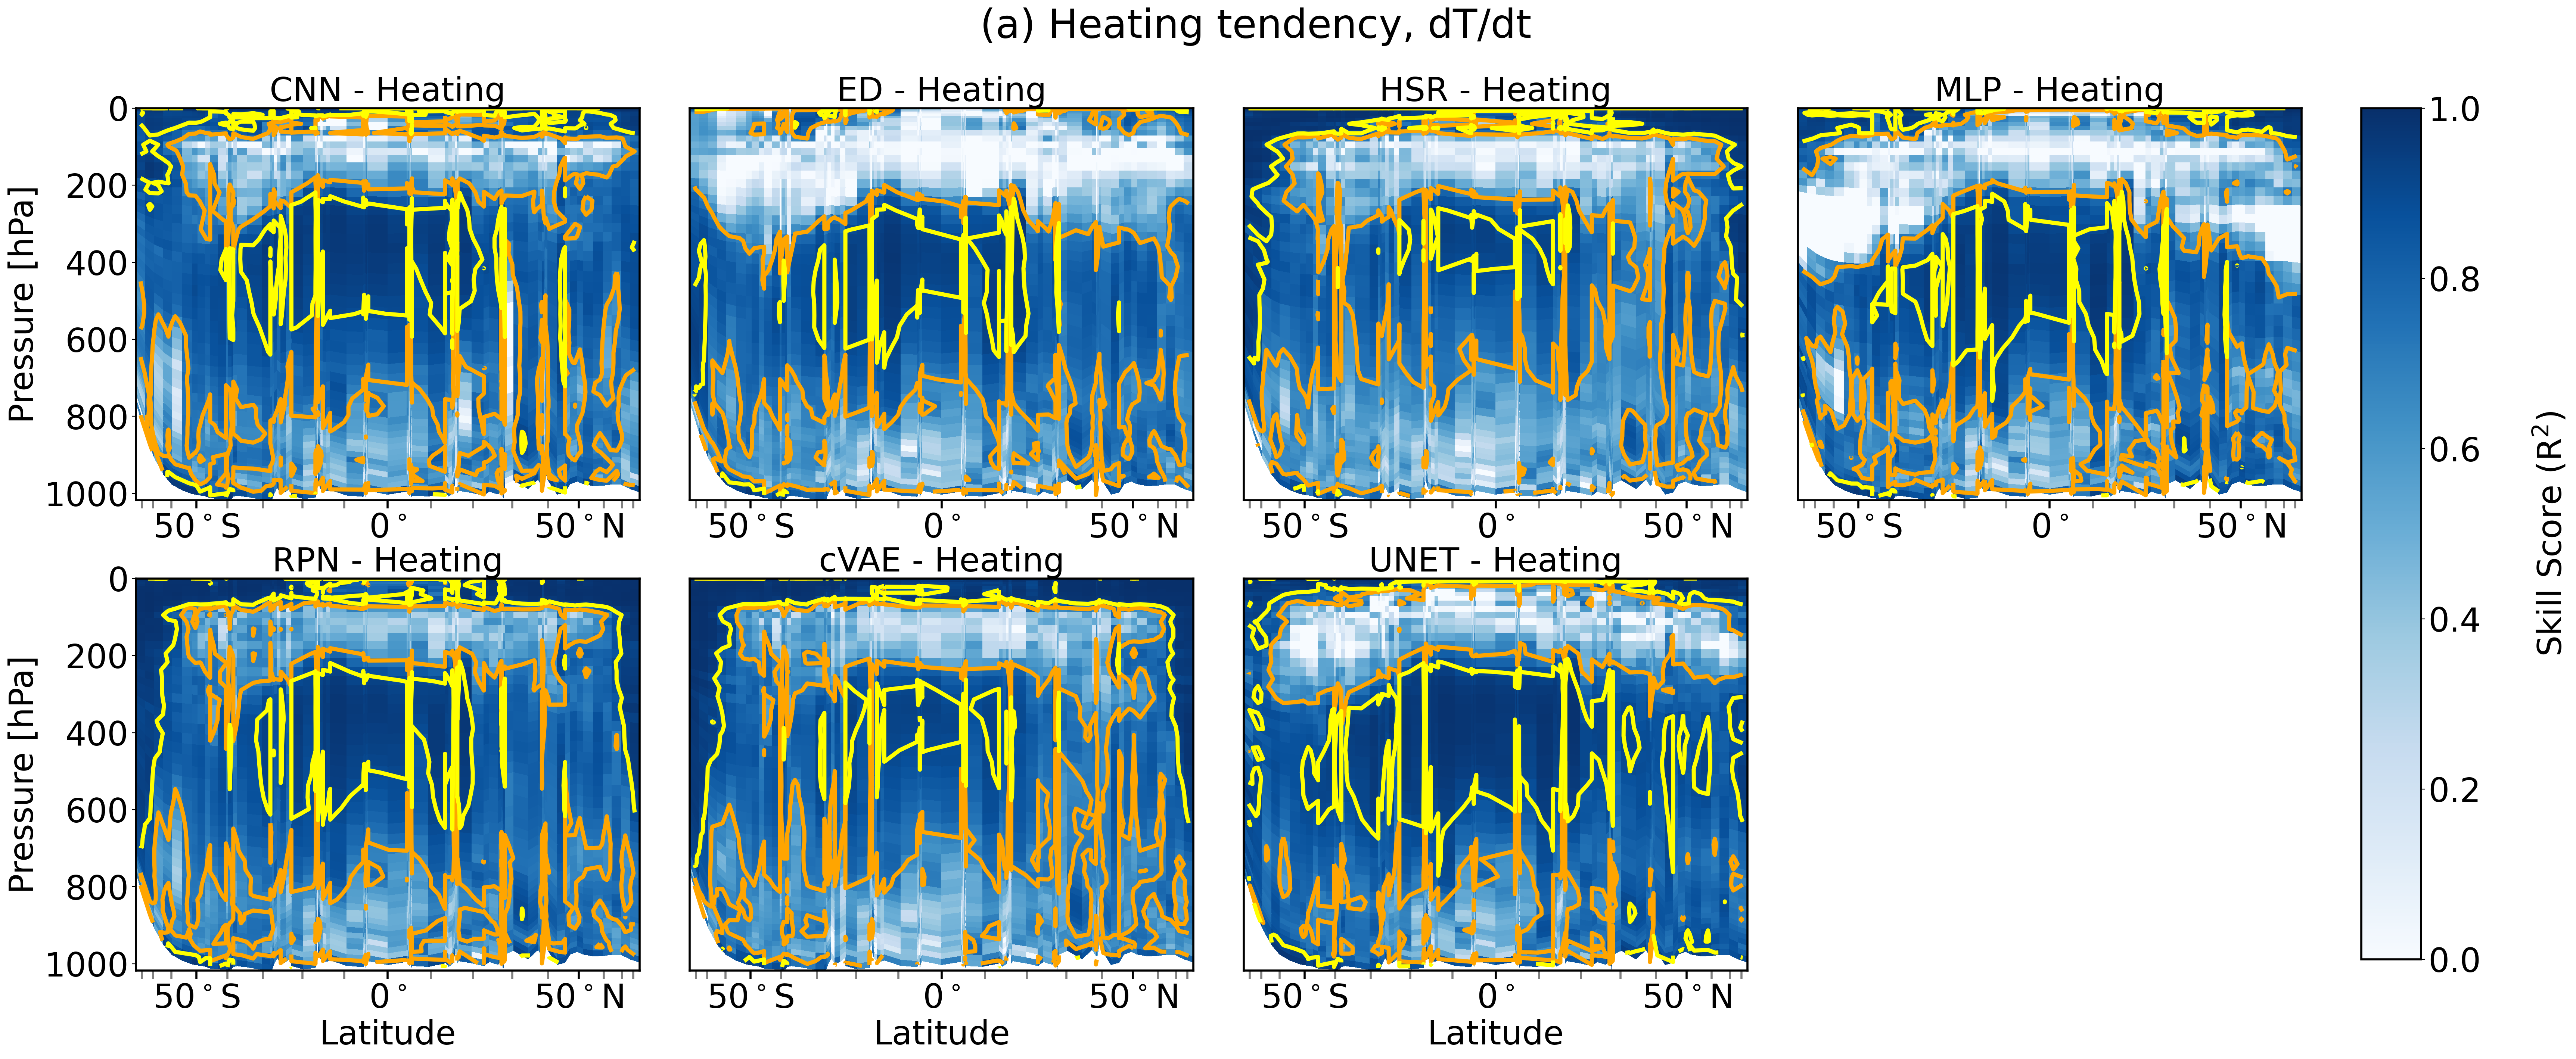

In [30]:
scoring_data.plot_r2_analysis(pressure_grid_plotting = pressure_grid_plotting, 
                              save_path='figs/r2-zonal-heating-tendency.pdf',figsize = (40,15), 
                              suptitle='(a) Heating tendency, dT/dt')

/var/tmp/ipykernel_91161/954900579.py:37: RuntimeWarning: divide by zero encountered in divide
  coeff = 1 - np.sum((pred_moist_daily_long - test_moist_daily_long)**2, axis=1) / \
/var/tmp/ipykernel_91161/954900579.py:44: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  contour_plot = ax[row, col].pcolor(X, Y, coeff, cmap='Blues', vmin=0, vmax=1, rasterized=True)
/var/tmp/ipykernel_91161/954900579.py:104: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = fig.colorbar(contour_plot, cax=cbar_ax)


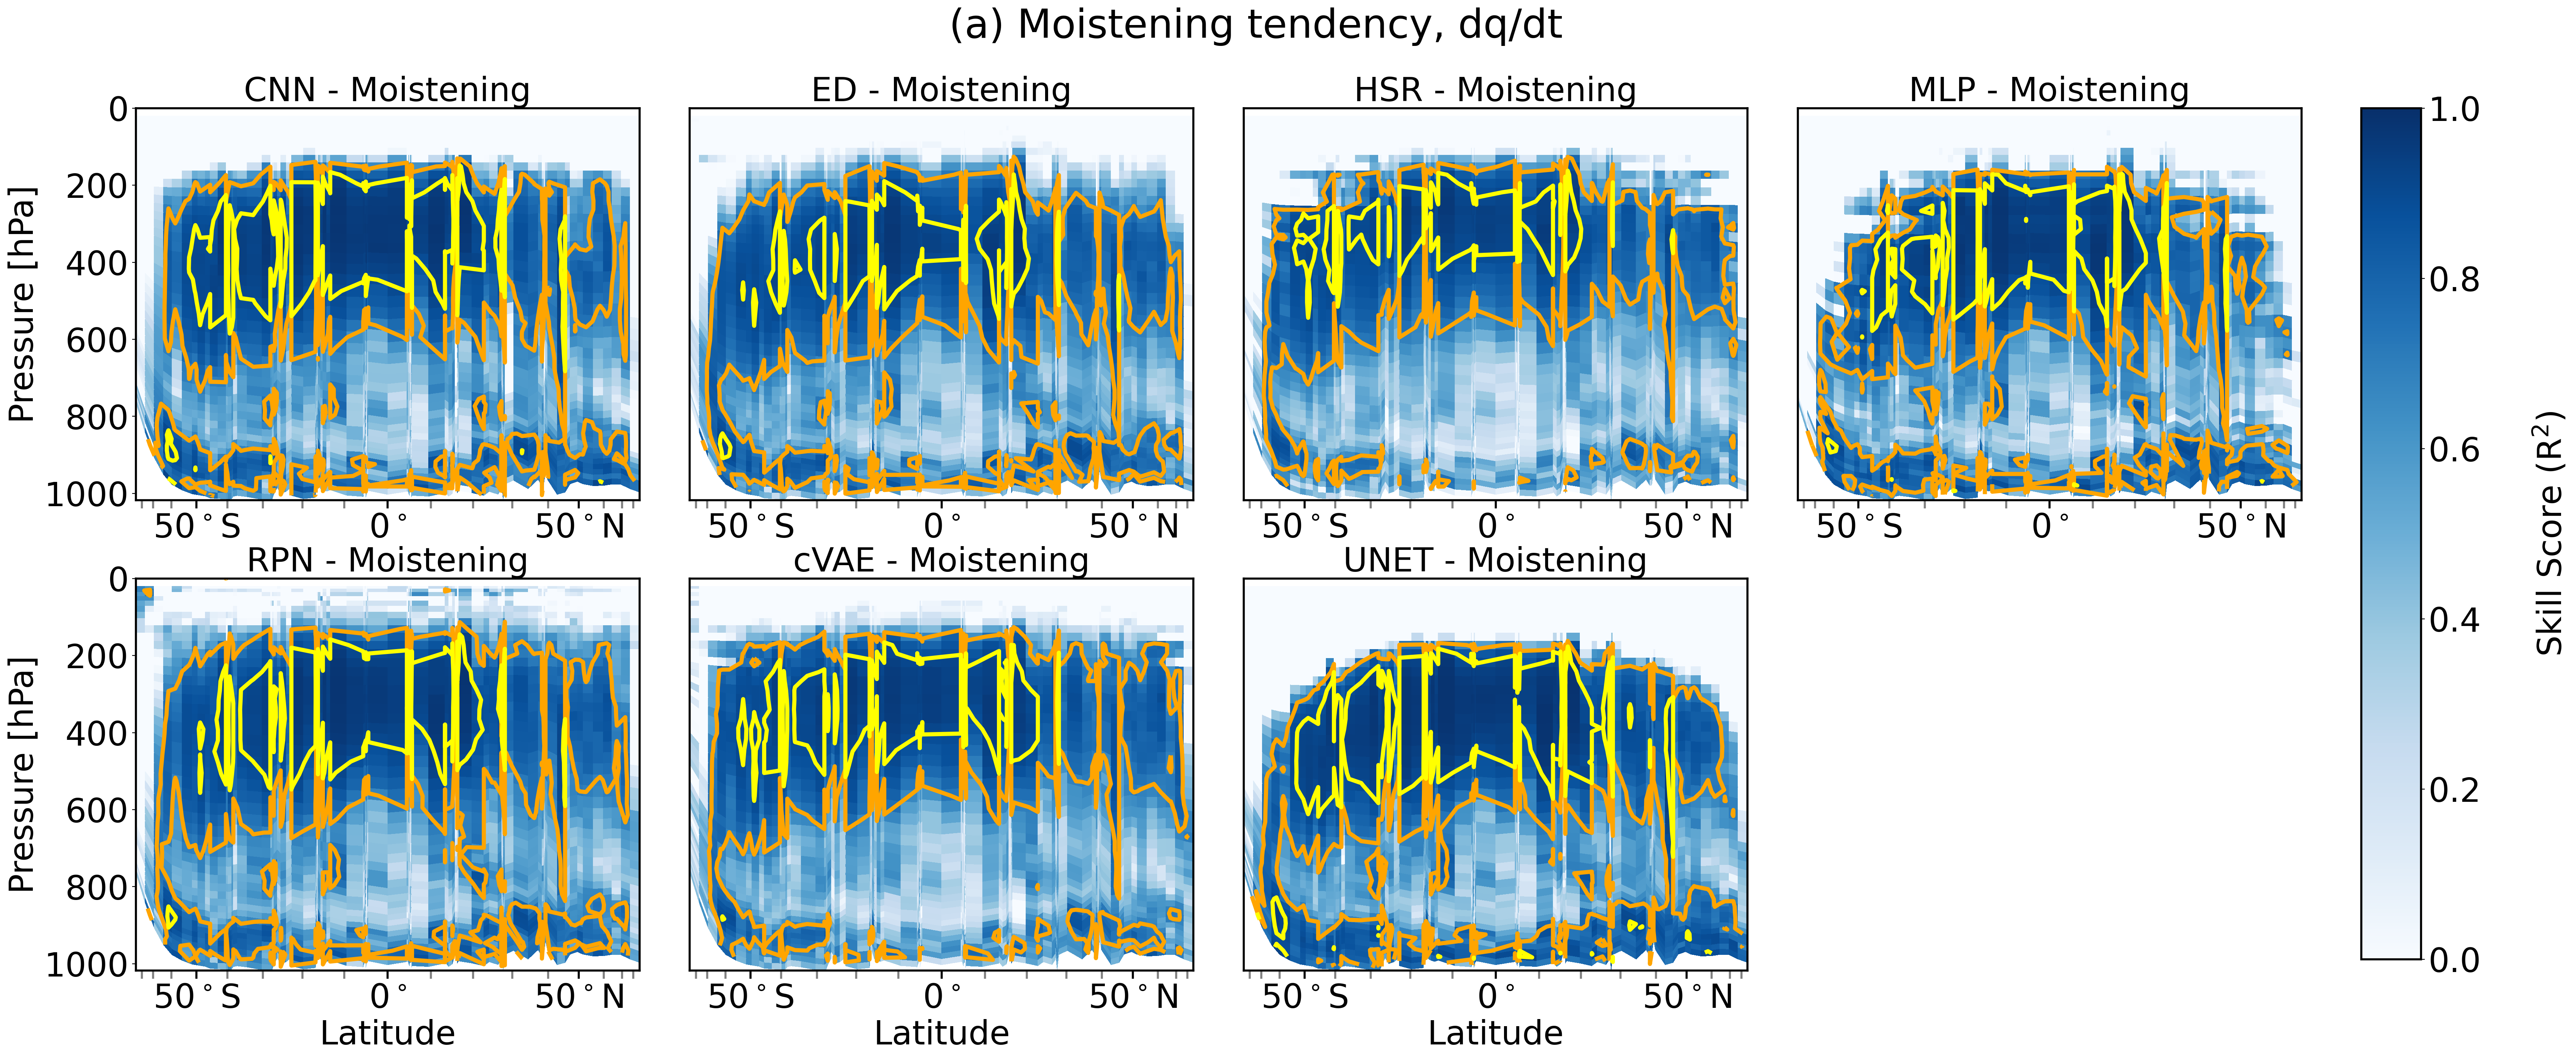

In [31]:
scoring_data.plot_r2_analysis(pressure_grid_plotting = pressure_grid_plotting, tendency='moistening', 
                              save_path='figs/r2-zonal-moistening-tendency.pdf',figsize = (40,15), 
                              suptitle='(a) Moistening tendency, dq/dt')